In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from sklearn.model_selection import train_test_split
import lightgbm as lgb

/var/folders/_v/78p688311b1406y84pvwbn4c0000gp/T/ipykernel_81754/2850567124.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
df_train = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/train.csv")
target_train = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/target_train.csv")
df_test = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/test.csv")
sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv")

df_train_with_target = df_train.merge(target_train,on="ID")

df_all = pd.concat([df_train,df_test])

df_all_with_target = df_all.merge(target_train,how="left",on="ID")

In [3]:
df_all_with_target_fe = df_all_with_target.copy()

df_all_with_target_fe["log_open"] = np.log(df_all_with_target_fe["open"])
df_all_with_target_fe["log_high"] = np.log(df_all_with_target_fe["high"])
df_all_with_target_fe["log_low"] = np.log(df_all_with_target_fe["low"])
df_all_with_target_fe["log_close"] = np.log(df_all_with_target_fe["close"])
df_all_with_target_fe["mid_price"] = (df_all_with_target_fe["high"] + df_all_with_target_fe["low"]) / 2

df_all_with_target_fe["lag_mid_price"] = df_all_with_target_fe["mid_price"].shift(1)
df_all_with_target_fe["lag_log_high"] = df_all_with_target_fe["log_high"].shift(1)
df_all_with_target_fe["lag_log_low"] = df_all_with_target_fe["log_low"].shift(1)
df_all_with_target_fe["lag_log_close"] = df_all_with_target_fe["log_close"].shift(1)

df_all_with_target_fe["x1"] = (df_all_with_target_fe["mid_price"] - df_all_with_target_fe["log_open"]) * (df_all_with_target_fe["log_open"] - df_all_with_target_fe["lag_mid_price"]) + ((df_all_with_target_fe["mid_price"] - df_all_with_target_fe["lag_log_close"]) * (df_all_with_target_fe["lag_log_close"]-df_all_with_target_fe["lag_mid_price"]))
df_all_with_target_fe["x2"] = (df_all_with_target_fe["mid_price"] - df_all_with_target_fe["log_open"]) * (df_all_with_target_fe["log_open"] - df_all_with_target_fe["lag_log_close"]) + ((df_all_with_target_fe["log_open"] - df_all_with_target_fe["lag_log_close"]) * (df_all_with_target_fe["lag_log_close"]-df_all_with_target_fe["lag_mid_price"]))

df_all_with_target_fe["expiry"] = df_all_with_target_fe["dt_expiry"] - df_all_with_target_fe["dt_close"]
df_all_with_target_fe["diff_high_low"] = df_all_with_target_fe["high"] - df_all_with_target_fe["low"]
df_all_with_target_fe["diff_close_open"] = df_all_with_target_fe["close"] - df_all_with_target_fe["open"]

df_all_with_target_fe["diff_high_low_angle_cos"] = df_all_with_target_fe["diff_high_low"] / (df_all_with_target_fe["diff_high_low"] ** 2 + 1)
df_all_with_target_fe["diff_close_open_angle_cos"] = df_all_with_target_fe["diff_close_open"] / (df_all_with_target_fe["diff_close_open"] ** 2 + 1)

df_all_with_target_fe["diff_high_low_angle_sin"] = 1 / (df_all_with_target_fe["diff_high_low"] ** 2 + 1)
df_all_with_target_fe["diff_close_open_angle_sin"] = 1 / (df_all_with_target_fe["diff_close_open"] ** 2 + 1)

df_all_with_target_fe["percent_high_low"] = df_all_with_target_fe["diff_high_low"] / df_all_with_target_fe["open"]
df_all_with_target_fe["percent_close_open"] = df_all_with_target_fe["diff_close_open"] / df_all_with_target_fe["open"]

In [4]:
periods = [3, 5, 10, 15, 25, 50, 100]
global_cols = ["volume","diff_high_low","diff_close_open","percent_close_open","percent_high_low","diff_high_low_angle_cos","diff_close_open_angle_cos","diff_high_low_angle_sin","diff_close_open_angle_sin"]
ls_global_fe = []
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank].sort_values("dt_close")
        ls_mask_fe_unit = []
        for col in global_cols:
            for p in periods:
                roll_mean = df_pid_rank[col].rolling(p, min_periods=1,center=True).mean().rename(f"{col}_mean_{p}")
                roll_std = df_pid_rank[col].rolling(p, min_periods=1,center=True).std().rename(f"{col}_std_{p}")
                ls_mask_fe_unit.append(roll_mean)
                ls_mask_fe_unit.append(roll_std)                
        ls_global_fe.append(ls_mask_fe_unit)
df_global_fe = pd.concat(pd.concat(unit_ex,axis=1) for unit_ex in ls_global_fe)
df_all_with_target_fe = pd.concat([df_all_with_target_fe, df_global_fe],axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:30<00:00,  3.47it/s]


In [5]:
def is_next_period(row, max_ex, min_ex):
    #if row["expiry"] > max_ex * 0.3 and (row["expiry"] - row["last_expiry"]) > (max_ex-min_ex) * 0.3:
    if row["expiry"] - row["last_expiry"] > 0:
        return 1
    else: return 0
    
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank].sort_values("dt_close")
        df_pid_rank["last_expiry"] = df_pid_rank["expiry"].shift(1)
        max_ex, min_ex = df_pid_rank["expiry"].max(),df_pid_rank["expiry"].min()
        df_pid_rank["num_period"] = df_pid_rank.apply(is_next_period,axis=1, args=(max_ex, min_ex)).cumsum()
        df_all_with_target_fe.loc[df_pid_rank.index,"num_period"] = df_pid_rank["num_period"]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:34<00:00,  3.00it/s]


In [6]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_
                      
dict_agg = {
            "period_high_std" : pd.NamedAgg(column="high", aggfunc=np.std),
            "period_low_std" : pd.NamedAgg(column="low", aggfunc=np.std),
            "period_open_std" : pd.NamedAgg(column="open", aggfunc=np.std),
            "period_close_std" : pd.NamedAgg(column="close", aggfunc=np.std),
            "period_dco_std" : pd.NamedAgg(column="diff_close_open", aggfunc=np.std),
            "period_dhl_std" : pd.NamedAgg(column="diff_high_low", aggfunc=np.std),
    
            "period_high_mean" : pd.NamedAgg(column="high", aggfunc=np.mean),
            "period_low_mean" : pd.NamedAgg(column="low", aggfunc=np.mean),
            "period_open_mean" : pd.NamedAgg(column="open", aggfunc=np.mean),
            "period_close_mean" : pd.NamedAgg(column="close", aggfunc=np.mean),
            "period_dco_mean" : pd.NamedAgg(column="diff_close_open", aggfunc=np.mean),
            "period_dhl_mean" : pd.NamedAgg(column="diff_high_low", aggfunc=np.mean),
    
            "period_x1_mean" : pd.NamedAgg(column="x1", aggfunc=np.mean),  
            "period_x1_var" : pd.NamedAgg(column="x1", aggfunc=np.var), 
            "period_x2_mean" : pd.NamedAgg(column="x2", aggfunc=np.mean),   
            "period_x2_var" : pd.NamedAgg(column="x2", aggfunc=np.var),
    
    
            "period_diff_high_low_angle_cos_mean" : pd.NamedAgg(column="diff_high_low_angle_cos", aggfunc=np.mean),
            "period_diff_high_low_angle_cos_std" : pd.NamedAgg(column="diff_high_low_angle_cos", aggfunc=np.std),
    
            "period_diff_close_open_angle_cos_mean" : pd.NamedAgg(column="diff_close_open_angle_cos", aggfunc=np.mean),
            "period_diff_close_open_angle_cos_std" : pd.NamedAgg(column="diff_close_open_angle_cos", aggfunc=np.std),
    
            "period_diff_high_low_angle_sin_mean" : pd.NamedAgg(column="diff_high_low_angle_sin", aggfunc=np.mean),
            "period_diff_high_low_angle_sin_std" : pd.NamedAgg(column="diff_high_low_angle_sin", aggfunc=np.std),
    
            "period_diff_close_open_angle_sin_mean" : pd.NamedAgg(column="diff_close_open_angle_sin", aggfunc=np.mean),
            "period_diff_close_open_angle_sin_std" : pd.NamedAgg(column="diff_close_open_angle_sin", aggfunc=np.std),
    

            "period_phl_mean" : pd.NamedAgg(column="percent_high_low", aggfunc=np.mean),
            "period_phl_std" : pd.NamedAgg(column="percent_high_low", aggfunc=np.std),   
            "period_pco_mean" : pd.NamedAgg(column="percent_close_open", aggfunc=np.mean),
            "period_pco_std" : pd.NamedAgg(column="percent_close_open", aggfunc=np.std),   
            "period_interest_mean" : pd.NamedAgg(column="open_interest", aggfunc=np.mean),
            "period_interest_std" : pd.NamedAgg(column="open_interest", aggfunc=np.std), 
            "period_interest_quantile25" : pd.NamedAgg(column="open_interest", aggfunc=percentile(25)),
            "period_interest_quantile75" : pd.NamedAgg(column="open_interest", aggfunc=percentile(75)),
            "period_volume_mean" : pd.NamedAgg(column="volume", aggfunc=np.mean),
            "period_volume_std" : pd.NamedAgg(column="volume", aggfunc=np.std), 
            "period_volume_quantile25" : pd.NamedAgg(column="volume", aggfunc=percentile(25)),
            "period_volume_quantile75" : pd.NamedAgg(column="volume", aggfunc=percentile(75)),
}
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        period_mean_std = df_pid_rank.groupby("num_period").agg(
                                                            **dict_agg
                                                            )
        df_pid_rank_period_merge = df_pid_rank[["num_period"]].merge(period_mean_std,how="left",left_on="num_period",right_index=True).drop("num_period",axis=1)
        df_all_with_target_fe.loc[df_pid_rank.index,df_pid_rank_period_merge.columns] = df_pid_rank_period_merge

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [01:03<00:00,  1.63it/s]


In [7]:
for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        for period in df_pid_rank.num_period.unique():
            df_pid_rank_period = df_pid_rank[df_pid_rank.num_period == period]
            
            w1 = df_pid_rank_period["period_x1_var"] / (df_pid_rank_period["period_x1_var"] + df_pid_rank_period["period_x2_var"])
            w2 = df_pid_rank_period["period_x2_var"] / (df_pid_rank_period["period_x1_var"] + df_pid_rank_period["period_x2_var"])
            k = 4 * w1 * w2
            
            df_all_with_target_fe.loc[w1.index,"period_w1"] = w1
            df_all_with_target_fe.loc[w2.index,"period_w2"] = w2
            df_all_with_target_fe.loc[k.index,"period_k"] = k

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [01:51<00:00,  1.07s/it]


In [9]:
dict_rename1 = {"high":"high_diff","low":"low_diff","open":"open_diff","close":"close_diff","diff_close_open":"diff_close_open_diff","diff_high_low":"diff_high_low_diff","volume":"volume_diff"}
dict_rename2 = {"high":"high_diff_angle","low":"low_diff_angle","open":"open_diff_angle","close":"close_diff_angle","diff_close_open":"diff_close_open_diff_angle","diff_high_low":"diff_high_low_diff_angle","volume":"volume_diff_angle"}
dict_rename3 = {"high":"high_diff_angle2","low":"low_diff_angle2","open":"open_diff_angle2","close":"close_diff_angle2","diff_close_open":"diff_close_open_diff_angle2","diff_high_low":"diff_high_low_diff_angle2","volume":"volume_diff_angle2"}

for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        period_diff = df_pid_rank.groupby("num_period")[["high","low","open","close","diff_close_open","diff_high_low","volume"]].diff(1)
        period_diff_1 = period_diff.rename(dict_rename1,axis=1)
        df_all_with_target_fe.loc[period_diff_1.index,period_diff_1.columns] = period_diff_1
        
        period_diff_2 = (period_diff / (period_diff ** 2 + 1)).rename(dict_rename2,axis=1)
        df_all_with_target_fe.loc[period_diff_2.index,period_diff_2.columns] = period_diff_2
        
        period_diff_3 = (1/ (period_diff ** 2 + 1)).rename(dict_rename3,axis=1)
        df_all_with_target_fe.loc[period_diff_3.index,period_diff_3.columns] = period_diff_3
        
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:17<00:00,  5.87it/s]


In [10]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

dict_agg = {
            "period_high_std" : pd.NamedAgg(column="high", aggfunc=np.std),
            "period_low_std" : pd.NamedAgg(column="low", aggfunc=np.std),
            "period_open_std" : pd.NamedAgg(column="open", aggfunc=np.std),
            "period_close_std" : pd.NamedAgg(column="close", aggfunc=np.std),
            "period_dco_std" : pd.NamedAgg(column="diff_close_open", aggfunc=np.std),
            "period_dhl_std" : pd.NamedAgg(column="diff_high_low", aggfunc=np.std),
    
            "period_high_mean" : pd.NamedAgg(column="high", aggfunc=np.mean),
            "period_low_mean" : pd.NamedAgg(column="low", aggfunc=np.mean),
            "period_open_mean" : pd.NamedAgg(column="open", aggfunc=np.mean),
            "period_close_mean" : pd.NamedAgg(column="close", aggfunc=np.mean),
            "period_dco_mean" : pd.NamedAgg(column="diff_close_open", aggfunc=np.mean),
            "period_dhl_mean" : pd.NamedAgg(column="diff_high_low", aggfunc=np.mean),
    
            "period_diff_high_low_angle_cos_mean" : pd.NamedAgg(column="diff_high_low_angle_cos", aggfunc=np.mean),
            "period_diff_high_low_angle_cos_std" : pd.NamedAgg(column="diff_high_low_angle_cos", aggfunc=np.std),
    
            "period_diff_close_open_angle_cos_mean" : pd.NamedAgg(column="diff_close_open_angle_cos", aggfunc=np.mean),
            "period_diff_close_open_angle_cos_std" : pd.NamedAgg(column="diff_close_open_angle_cos", aggfunc=np.std),
    
            "period_diff_high_low_angle_sin_mean" : pd.NamedAgg(column="diff_high_low_angle_sin", aggfunc=np.mean),
            "period_diff_high_low_angle_sin_std" : pd.NamedAgg(column="diff_high_low_angle_sin", aggfunc=np.std),
    
            "period_diff_close_open_angle_sin_mean" : pd.NamedAgg(column="diff_close_open_angle_sin", aggfunc=np.mean),
            "period_diff_close_open_angle_sin_std" : pd.NamedAgg(column="diff_close_open_angle_sin", aggfunc=np.std),
    

            "period_phl_mean" : pd.NamedAgg(column="percent_high_low", aggfunc=np.mean),
            "period_phl_std" : pd.NamedAgg(column="percent_high_low", aggfunc=np.std),   
            "period_pco_mean" : pd.NamedAgg(column="percent_close_open", aggfunc=np.mean),
            "period_pco_std" : pd.NamedAgg(column="percent_close_open", aggfunc=np.std),   
            "period_interest_mean" : pd.NamedAgg(column="open_interest", aggfunc=np.mean),
            "period_interest_std" : pd.NamedAgg(column="open_interest", aggfunc=np.std), 
            "period_interest_quantile25" : pd.NamedAgg(column="open_interest", aggfunc=percentile(25)),
            "period_interest_quantile75" : pd.NamedAgg(column="open_interest", aggfunc=percentile(75)),
            "period_volume_mean" : pd.NamedAgg(column="volume", aggfunc=np.mean),
            "period_volume_std" : pd.NamedAgg(column="volume", aggfunc=np.std), 
            "period_volume_quantile25" : pd.NamedAgg(column="volume", aggfunc=percentile(25)),
            "period_volume_quantile75" : pd.NamedAgg(column="volume", aggfunc=percentile(75)),
}

for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        expiry_mean_std = df_pid_rank.groupby("expiry").agg(**dict_agg)
        df_pid_rank_expiry_merge = df_pid_rank[["expiry"]].merge(expiry_mean_std,how="left",left_on="expiry",right_index=True).drop("expiry",axis=1)
        df_all_with_target_fe.loc[df_pid_rank.index,df_pid_rank_expiry_merge.columns] = df_pid_rank_expiry_merge

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:52<00:00,  1.99it/s]


In [11]:
dict_rename1 = {"high":"e_high_diff","low":"e_low_diff","open":"e_open_diff","close":"e_close_diff","diff_close_open":"e_diff_close_open_diff","diff_high_low":"e_diff_high_low_diff","volume":"e_volume_diff"}
dict_rename2 = {"high":"e_high_diff_angle","low":"e_low_diff_angle","open":"e_open_diff_angle","close":"e_close_diff_angle","diff_close_open":"e_diff_close_open_diff_angle","diff_high_low":"e_diff_high_low_diff_angle","volume":"e_volume_diff_angle"}
dict_rename3 = {"high":"e_high_diff_angle2","low":"e_low_diff_angle2","open":"e_open_diff_angle2","close":"e_close_diff_angle2","diff_close_open":"e_diff_close_open_diff_angle2","diff_high_low":"e_diff_high_low_diff_angle2","volume":"e_volume_diff_angle2"}

for pid in tqdm(df_all_with_target_fe.product_id.unique()):
    df_pid = df_all_with_target_fe[df_all_with_target_fe.product_id == pid]
    for rank in df_pid.liquidity_rank.unique():
        df_pid_rank = df_pid[df_pid.liquidity_rank == rank]
        
        period_diff = df_pid_rank.groupby("expiry")[["high","low","open","close","diff_close_open","diff_high_low","volume"]].diff(1)
        period_diff_1 = period_diff.rename(dict_rename1,axis=1)
        df_all_with_target_fe.loc[period_diff_1.index,period_diff_1.columns] = period_diff_1
        
        period_diff_2 = (period_diff / (period_diff ** 2 + 1)).rename(dict_rename2,axis=1)
        df_all_with_target_fe.loc[period_diff_2.index,period_diff_2.columns] = period_diff_2
        
        period_diff_3 = (1/ (period_diff ** 2 + 1)).rename(dict_rename3,axis=1)
        df_all_with_target_fe.loc[period_diff_3.index,period_diff_3.columns] = period_diff_3

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.57it/s]


In [24]:
df_learn_clean = pd.read_pickle("df_mask_pid4_with_fillna.pkl")

In [25]:
cols_spread = [col for col in df_learn_clean if col.startswith('spread_')] + [col for col in df_learn_clean if col.startswith('interp')] + [col for col in df_learn_clean if col.endswith('_spread')]
#cols_conserved = cols_spread + list(df_train_with_target.columns)

cols_conserved = cols_spread[:-1] + ["ID"]

In [26]:
df_learn_clean_new = df_learn_clean[cols_conserved].merge(df_all_with_target_fe,on="ID",how="left")

In [27]:
# with old features
features = df_learn_clean_new.columns.drop(["ID","spread"])
params = {'learning_rate': 0.1, 'num_leaves': 256, 'max_depth': 8,"min_data_in_leaf":50,
    'subsample': 0.8, 
    'colsample_bytree': 0.6 ,'objective': 'regression','metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)

train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                            df_learn_clean_new.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                          df_learn_clean_new.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.620247	vl's rmse: 0.709707
[200]	tr's rmse: 0.553388	vl's rmse: 0.698037
[300]	tr's rmse: 0.507697	vl's rmse: 0.69262
[400]	tr's rmse: 0.469036	vl's rmse: 0.688765
[500]	tr's rmse: 0.436865	vl's rmse: 0.685976
[600]	tr's rmse: 0.41052	vl's rmse: 0.684088
[700]	tr's rmse: 0.386572	vl's rmse: 0.682159
[800]	tr's rmse: 0.366351	vl's rmse: 0.681119
[900]	tr's rmse: 0.348101	vl's rmse: 0.679833
[1000]	tr's rmse: 0.332275	vl's rmse: 0.678871
[1100]	tr's rmse: 0.316639	vl's rmse: 0.678254
[1200]	tr's rmse: 0.302886	vl's rmse: 0.677313
[1300]	tr's rmse: 0.289553	vl's rmse: 0.676645
[1400]	tr's rmse: 0.278157	vl's rmse: 0.676128
[1500]	tr's rmse: 0.26818	vl's rmse: 0.675633
[1600]	tr's rmse: 0.257723	vl's rmse: 0.675292
[1700]	tr's rmse: 0.247889	vl's rmse: 0.674914
[1800]	tr's rmse: 0.238786	vl's rmse: 0.674647
[1900]	tr's rmse: 0.230627	vl's rmse: 0.674264
[2000]	tr's rmse: 0.222619	vl's rmse: 0.673787
[2100]	tr's

In [18]:
# with old features
features = df_learn_clean_new.columns.drop(["ID","spread"])
params = {'learning_rate': 0.1, 'num_leaves': 256, 'max_depth': 8,"min_data_in_leaf":50,
    'subsample': 0.8, 
    'colsample_bytree': 0.6 ,'objective': 'regression','metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)

train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
        

import lightgbm as lgb
train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                            df_learn_clean_new.loc[train_idx, "spread"].values, 
                            #feature_name = features, 
                           )
val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                          df_learn_clean_new.loc[valid_idx, "spread"].values, 
                          #feature_name = features, 
                         )

model_all = lgb.train(params = params,
                  train_set = train_dataset, 
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round = 15000,
                  verbose_eval = 100,    
                  categorical_feature=["fixed","normal_trading_day",]
                 )

/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict 

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.629356	vl's rmse: 0.715238
[200]	tr's rmse: 0.562348	vl's rmse: 0.703682
[300]	tr's rmse: 0.516693	vl's rmse: 0.697568
[400]	tr's rmse: 0.479837	vl's rmse: 0.693224
[500]	tr's rmse: 0.450702	vl's rmse: 0.690323
[600]	tr's rmse: 0.423027	vl's rmse: 0.688352
[700]	tr's rmse: 0.399031	vl's rmse: 0.686757
[800]	tr's rmse: 0.377674	vl's rmse: 0.685685
[900]	tr's rmse: 0.359148	vl's rmse: 0.684083
[1000]	tr's rmse: 0.342031	vl's rmse: 0.68295
[1100]	tr's rmse: 0.326585	vl's rmse: 0.681961
[1200]	tr's rmse: 0.31254	vl's rmse: 0.681073
[1300]	tr's rmse: 0.299531	vl's rmse: 0.680082
[1400]	tr's rmse: 0.288662	vl's rmse: 0.6794
[1500]	tr's rmse: 0.277703	vl's rmse: 0.67899
[1600]	tr's rmse: 0.267681	vl's rmse: 0.678546
[1700]	tr's rmse: 0.258049	vl's rmse: 0.678048
[1800]	tr's rmse: 0.249143	vl's rmse: 0.677637
[1900]	tr's rmse: 0.240601	vl's rmse: 0.677302
[2000]	tr's rmse: 0.232541	vl's rmse: 0.677108
[2100]	tr's r

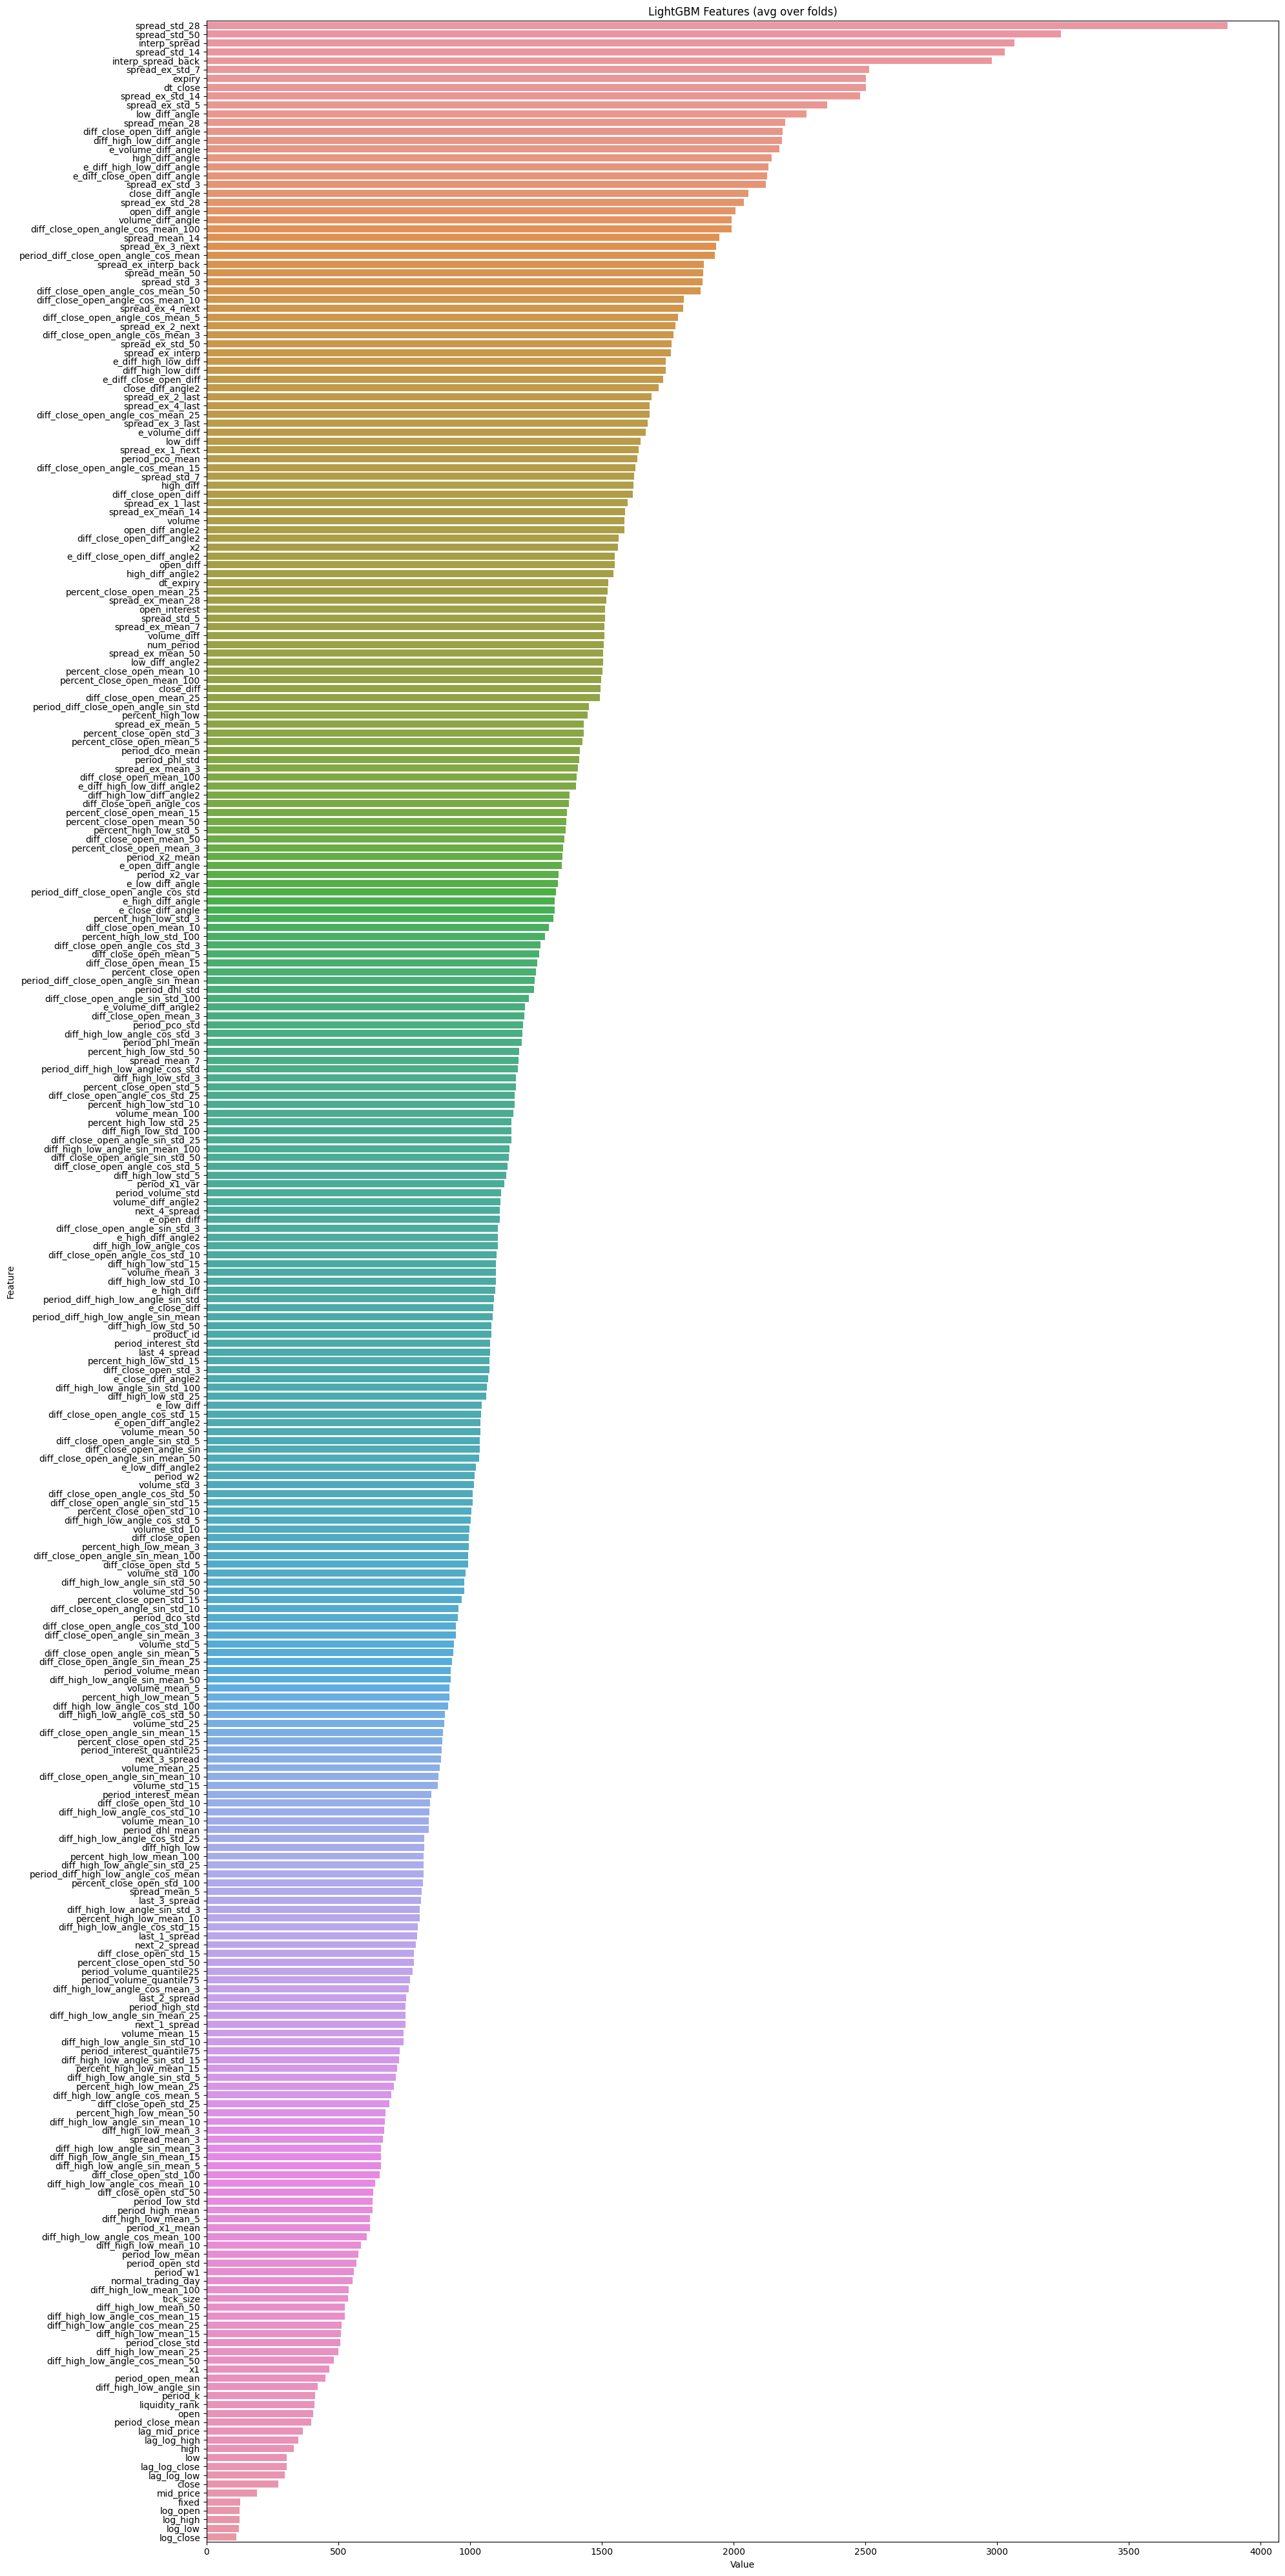

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model_all.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [33]:
params = {"learning_rate":0.05, 'objective': 'regression','num_leaves': 192, 'max_depth': 8,
    'subsample': 0.8, 
    'colsample_bytree': 0.8,'metric': 'rmse','early_stopping_rounds': 50,"verbose":-1}

features = df_learn_clean_new.columns.drop(["ID","spread"])



nfold = 5
val_scores = []
for fold_id in range(nfold):
    print("Fold %d / %d" % (fold_id + 1, nfold))
    id_ti, id_vi = train_test_split(df_learn_clean_new["ID"].unique(),test_size=0.2)
    train_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_ti)].index
    valid_idx = df_learn_clean_new[df_learn_clean_new["ID"].isin(id_vi)].index
    

    train_dataset = lgb.Dataset(df_learn_clean_new.loc[train_idx, features],
                                df_learn_clean_new.loc[train_idx, "spread"].values, 
                                #feature_name = features, 
                               )
    val_dataset = lgb.Dataset(df_learn_clean_new.loc[valid_idx, features], 
                              df_learn_clean_new.loc[valid_idx, "spread"].values, 
                              #feature_name = features, 
                             )
    
    res = {}
    
    gbm = lgb.train(params, train_dataset, num_boost_round=20000, 
                    valid_sets=[train_dataset, val_dataset], valid_names=['tr', 'vl'],
                    categorical_feature=["fixed","normal_trading_day"],
                    evals_result=res, verbose_eval=100)
    
    gbm.save_model('models/all_1612/lightgbm_model_%d.txt' % fold_id)
    
    val_scores.append(res['vl']['rmse'][-1])
print("avg_val_score: %4f" % (np.mean(val_scores)))

Fold 1 / 5


/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fixed', 'normal_trading_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/XIAOZHO/opt/anaconda3/envs/cfm/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release

Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.668317	vl's rmse: 0.714169
[200]	tr's rmse: 0.608515	vl's rmse: 0.695998
[300]	tr's rmse: 0.567339	vl's rmse: 0.688349
[400]	tr's rmse: 0.536368	vl's rmse: 0.683973
[500]	tr's rmse: 0.507194	vl's rmse: 0.680257
[600]	tr's rmse: 0.483267	vl's rmse: 0.677167
[700]	tr's rmse: 0.460826	vl's rmse: 0.674757
[800]	tr's rmse: 0.440671	vl's rmse: 0.672981
[900]	tr's rmse: 0.423237	vl's rmse: 0.671133
[1000]	tr's rmse: 0.407711	vl's rmse: 0.669608
[1100]	tr's rmse: 0.392569	vl's rmse: 0.668365
[1200]	tr's rmse: 0.378408	vl's rmse: 0.667149
[1300]	tr's rmse: 0.365405	vl's rmse: 0.666405
[1400]	tr's rmse: 0.353801	vl's rmse: 0.665488
[1500]	tr's rmse: 0.342919	vl's rmse: 0.664616
[1600]	tr's rmse: 0.33237	vl's rmse: 0.663981
[1700]	tr's rmse: 0.32268	vl's rmse: 0.663466
[1800]	tr's rmse: 0.313085	vl's rmse: 0.662794
[1900]	tr's rmse: 0.305245	vl's rmse: 0.662384
[2000]	tr's rmse: 0.296772	vl's rmse: 0.661847
[2100]	tr'

[2400]	tr's rmse: 0.263515	vl's rmse: 0.671395
[2500]	tr's rmse: 0.256756	vl's rmse: 0.671026
[2600]	tr's rmse: 0.250516	vl's rmse: 0.6707
[2700]	tr's rmse: 0.24439	vl's rmse: 0.670278
[2800]	tr's rmse: 0.238777	vl's rmse: 0.6699
[2900]	tr's rmse: 0.233604	vl's rmse: 0.669653
[3000]	tr's rmse: 0.228325	vl's rmse: 0.669331
[3100]	tr's rmse: 0.223114	vl's rmse: 0.669078
[3200]	tr's rmse: 0.218282	vl's rmse: 0.668829
[3300]	tr's rmse: 0.213635	vl's rmse: 0.6686
[3400]	tr's rmse: 0.208927	vl's rmse: 0.668405
[3500]	tr's rmse: 0.20484	vl's rmse: 0.668221
[3600]	tr's rmse: 0.20029	vl's rmse: 0.667991
[3700]	tr's rmse: 0.196372	vl's rmse: 0.667836
[3800]	tr's rmse: 0.192371	vl's rmse: 0.667634
[3900]	tr's rmse: 0.18847	vl's rmse: 0.667478
[4000]	tr's rmse: 0.184766	vl's rmse: 0.667364
[4100]	tr's rmse: 0.181284	vl's rmse: 0.6672
[4200]	tr's rmse: 0.177791	vl's rmse: 0.667063
[4300]	tr's rmse: 0.174388	vl's rmse: 0.666975
[4400]	tr's rmse: 0.17121	vl's rmse: 0.666824
[4500]	tr's rmse: 0.168262

In [34]:
df_test_all = pd.read_pickle("df_test_mask_pid4.pkl")
df_test_all_c = df_test_all[cols_conserved].merge(df_all_with_target_fe,on="ID",how="left")
features = df_test_all_c.columns.drop(["ID","spread"])

In [35]:
pred_all = np.zeros((df_test_all_c.shape[0],))
for fold_id in range(nfold):
    gbm = lgb.Booster(model_file = 'models/all_1612/lightgbm_model_%d.txt' % fold_id)
    current_pred = gbm.predict(df_test_all_c[features])
    pred_all += current_pred
pred_all /= nfold

In [36]:
df_test_all["feifei_final"] = pred_all

In [37]:
sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)
sub_new = sub.merge(df_test_all[["ID","feifei_final"]],on="ID").rename({"feifei_final":"spread"},axis=1)

In [38]:
aa = sub_new[sub_new.spread< 1]
sub_new.loc[aa.index,"spread"] = 1
bb = sub_new[sub_new.spread> 10]
sub_new.loc[bb.index,"spread"] = 10

In [39]:
sub_new.to_csv("submission_feifei_final_oclh_noblend.csv",index=False)

In [46]:
sub_no = pd.read_csv("submission_feifei_final_oclh_noblend.csv")

In [44]:
np.mean((sub_new.spread - sub_old.spread) ** 2)

0.005725530320978871

In [51]:
sub_new_old_no = pd.read_csv("submission_feifei_final_without_oclh_noblend.csv")

In [53]:
sub_no_blend = (sub_no.spread + sub_new_old_no.spread) / 2

In [55]:
np.mean((sub_old.spread - sub_no_blend) ** 2)

0.016127430538067682

In [57]:
0.498 ** 2

0.248004

In [58]:
0.493 ** 2

0.243049

In [52]:
np.mean((sub_no.spread - sub_new_old_no.spread) ** 2)

0.02057248542980084

In [48]:
sub_new_old = pd.read_csv("submission_feifei_final_without_oclh.csv")

In [50]:
np.mean((sub_new.spread - sub_new_old.spread) ** 2)

0.0051431213574502106

In [40]:
sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

In [41]:
sub_new_blend = (sub_new.spread + sub_old.spread) / 2

In [42]:
sub_new.spread = sub_new_blend

In [43]:
sub_new.to_csv("submission_feifei_final.csv",index=False)

In [30]:
df_test_all = pd.read_pickle("df_test_mask_pid4.pkl")
df_test_all_c = df_test_all[cols_conserved].merge(df_all_with_target_fe,on="ID",how="left")
features = df_test_all_c.columns.drop(["ID","spread"])
pred = model_all.predict(df_test_all_c[features])
s_pred = pd.Series(pred,index=df_test_all_c.index,name="spread")
df_pred = pd.concat([s_pred,df_test_all_c["ID"]],axis=1)

sub = pd.read_csv("/Users/XIAOZHO/Desktop/competition/cfm/data/submission.csv").drop("spread",axis=1)
sub_new = sub.merge(df_pred[["ID","spread"]],on="ID")

sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

np.mean((sub_new["spread"] - sub_old["spread"]) ** 2)

0.050970106163982905

In [31]:
sub_new

,ID,spread
0,1977,2.104954
1,1978,2.800159
2,1979,2.980263
3,1980,3.345314
4,1981,3.810901
...,...,...
230299,858592,1.036716
230300,858593,1.060527
230301,858594,1.152106
230302,858595,1.081888


In [66]:
xx = df_train_with_target[df_train_with_target.notnull()].spread

(array([6.10800425, 1.76705228, 1.45354301, 1.23436005, 1.05823719,
        0.93788069, 0.82449498, 0.72796272, 0.67343169, 0.62181252,
        0.58113484, 0.55316343, 0.52722148, 0.48336724, 0.45971948,
        0.44754265, 0.42883622, 0.42848327, 0.40121775, 0.38304075,
        0.37095215, 0.36354017, 0.3570988 , 0.34659849, 0.32718615,
        0.32312721, 0.32136245, 0.31456813, 0.31086214, 0.3030972 ,
        0.29930297, 0.30009711, 0.29321456, 0.2958617 , 0.28809676,
        0.30203835, 0.28677319, 0.2870379 , 0.28350839, 0.28836147,
        0.28262601, 0.28147892, 0.27944944, 0.28103773, 0.27892002,
        0.27839059, 0.26806676, 0.27477284, 0.27441988, 0.26894913,
        0.26356662, 0.26383134, 0.26744909, 0.26859618, 0.2870379 ,
        0.6215478 , 0.26400781, 0.24927208, 0.2495368 , 0.24830146,
        0.2432719 , 0.24053653, 0.23294807, 0.21653582, 0.23065388,
        0.21274159, 0.21944767, 0.20471194, 0.19685877, 0.20241775,
        0.19659405, 0.18318189, 0.19218216, 0.17

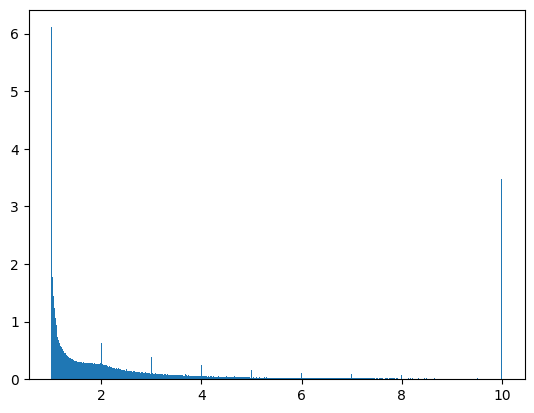

In [90]:
plt.hist(xx,bins=500,density=True)

(1.0, 2.0)

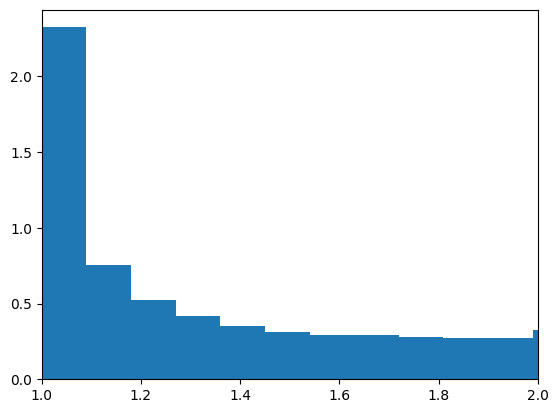

In [71]:
plt.hist(xx,bins=100,density=True)
plt.xlim([1,2])

In [84]:
sub_old = pd.read_csv("submission_mask_pid5_and_submission_mask_pid4_with_fillna_10fold_all_and_1511_0511_clean.csv")

In [85]:
aa = sub_old[(sub_old.spread> 9.05)]
sub_old.loc[aa.index,"spread"] = 10

In [87]:
sub_old.to_csv("submission_feifei_zhongtian_final.csv",index=False)

(array([3.41915227, 2.50827891, 1.99567142, 1.64034397, 1.36124427,
        1.17308717, 0.96900908, 0.7864002 , 0.65227796, 0.60861586,
        0.58787033, 0.56953708, 0.56447131, 0.52925216, 0.50175227,
        0.47401116, 0.42069998, 0.41539299, 0.4137044 , 0.38885801,
        0.34784941, 0.33313456, 0.34157751, 0.31287149, 0.32420916,
        0.3254153 , 0.31214781, 0.29863909, 0.30756449, 0.29260842,
        0.29743296, 0.29357333, 0.28199443, 0.30346363, 0.29019615,
        0.2969505 , 0.29839787, 0.27741111, 0.28681897, 0.27885847,
        0.28392424, 0.26727958, 0.27258657, 0.28030584, 0.27620498,
        0.26245504, 0.26245504, 0.27113921, 0.25835418, 0.26559099,
        0.26366117, 0.25135859, 0.26438485, 0.25931908, 0.24991123,
        0.23254288, 0.23133675, 0.26583221, 0.22723589, 0.2407446 ,
        0.2175868 , 0.22964816, 0.22506484, 0.20311318, 0.20817895,
        0.21083245, 0.21589821, 0.1908106 , 0.19684128, 0.20094214,
        0.19201674, 0.19997723, 0.18429747, 0.18

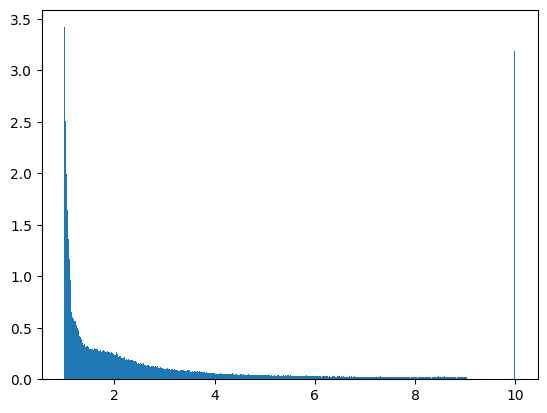

In [91]:
plt.hist(sub_old.spread,bins=500,density=True)

In [76]:
aa = sub_old[(sub_old.spread> 1.1) & (sub_old.spread< 9.5)]

In [77]:
sub_old.loc[aa.index,"spread"] = aa * 0.95

In [ ]:
aa = sub_old[(sub_old.spread> 1.95) & (sub_old.spread< 2.05)]
sub_old.loc[aa.index,"spread"] = aa * 1.2
aa = sub_old[(sub_old.spread> 2.95) & (sub_old.spread< 3.05)]
sub_old.loc[aa.index,"spread"] = aa * 1.2
aa = sub_old[(sub_old.spread> 3.95) & (sub_old.spread< 4.05)]
sub_old.loc[aa.index,"spread"] = aa * 1.2
aa = sub_old[(sub_old.spread> 4.95) & (sub_old.spread< 5.05)]
sub_old.loc[aa.index,"spread"] = aa * 1.2
aa = sub_old[(sub_old.spread> 5.95) & (sub_old.spread< 6.05)]
sub_old.loc[aa.index,"spread"] = aa * 1.2
aa = sub_old[(sub_old.spread> 6.95) & (sub_old.spread< 7.05)]
sub_old.loc[aa.index,"spread"] = aa * 1.2
aa = sub_old[(sub_old.spread> 7.95) & (sub_old.spread< 8.05)]
sub_old.loc[aa.index,"spread"] = aa * 1.2
aa = sub_old[(sub_old.spread> 8.95) & (sub_old.spread< 9.05)]
sub_old.loc[aa.index,"spread"] = aa * 1.2

(array([2.66102388, 0.75397928, 0.48052429, 0.36623091, 0.32835827,
        0.3101215 , 0.30327065, 0.29019615, 0.27726638, 0.26920939,
        0.24783668, 0.22742887, 0.21001227, 0.19587637, 0.17759136,
        0.15824495, 0.15105638, 0.1351354 , 0.13127576, 0.12017932,
        0.10888989, 0.10449956, 0.1025215 , 0.09171453, 0.09243821,
        0.08785489, 0.0793637 , 0.08076282, 0.07526284, 0.06961813,
        0.06368394, 0.05692958, 0.05664011, 0.05389012, 0.05591643,
        0.04882436, 0.04867962, 0.0478112 , 0.04535069, 0.04279368,
        0.04216649, 0.04486823, 0.04081562, 0.03936826, 0.03821037,
        0.03589459, 0.03821037, 0.03603932, 0.03497792, 0.03459196,
        0.03536389, 0.03343407, 0.03343407, 0.02991215, 0.03111829,
        0.02754813, 0.0299604 , 0.02947795, 0.02851304, 0.02740339,
        0.02590779, 0.02392972, 0.02648673, 0.02508761, 0.02431569,
        0.02407446, 0.02523235, 0.02373674, 0.02450867, 0.02171043,
        0.02180693, 0.02277183, 0.0215657 , 0.02

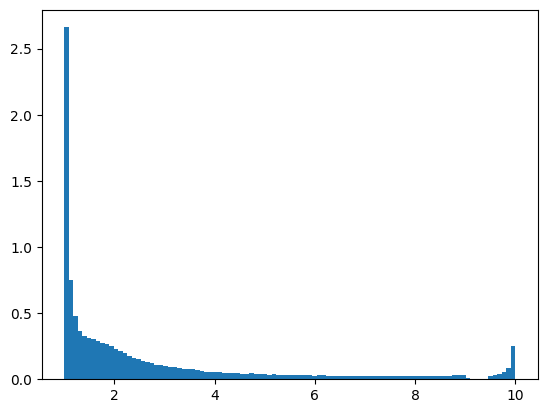

In [80]:
plt.hist(sub_old.spread,bins=100,density=True)

### 